<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/GPR_myLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install george

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 296kB 13.5MB/s 
  ERROR: Failed building wheel for george
  Running setup.py clean for george
Failed to build george
    Running setup.py install for george ... done


In [4]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [326]:
data = pd.read_excel('/content/drive/My Drive/Hailisu.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

# data["dET0"] = data["ET0"]-np.median(data["ET0"])

# data["ET1"] = data["ET0"] - data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
data["ET1"] = data["ET0"].shift(1, freq='D')
data["ET2"] = (data["ET0"] - data["ET1"])#/ data["ET1"]
data["ET2"] = data["ET2"].fillna(0)
# data["MA"] = data["ET0"].rolling('7d').apply(lambda x: x[:len(x)-1].mean())
# data["ET3"] = data["ET2"] - data["ET2"].shift(1, freq='D')

# data["ET3"].plot()


def F(key):
  data["tmp"] = data[key].shift(1, freq='D')
  data["tmp"] = (data[key] - data["tmp"])/ data["tmp"]
  data[key] = data["tmp"].fillna(0)

# F('Rn')
# F('VPD')
# F('T')


data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3,ET1,ET2
TIMESTAMP,,,,,,,,,,,,,,,,,
1990-01-01,1,4.5,-15.9,1.4,74.0,-20.3,-10.8,2.194157,0.049189,0.014773,0.067364,0.353247,-2.604686,0.219401,0.051999,NaN,0.000000
1990-01-02,2,6.3,-14.7,1.2,55.0,-21.6,-7.2,2.455747,0.098182,0.016148,0.067364,0.708336,-2.433856,0.237608,0.013234,0.353247,0.355089
1990-01-03,3,6.5,-10.5,1.8,63.0,-15.0,-5.6,2.851274,0.105714,0.021875,0.067364,0.773378,-2.218240,0.177261,0.023540,0.708336,0.065042
1990-01-04,4,6.8,-14.6,1.4,71.0,-18.5,-8.6,2.698292,0.057183,0.016267,0.067364,0.455943,-2.477608,0.140149,0.051026,0.773378,-0.317435
1990-01-05,5,5.8,-15.2,1.1,55.0,-22.2,-5.9,2.000768,0.090000,0.015562,0.067364,0.627822,-2.522159,0.310003,0.011304,0.455943,0.171879


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

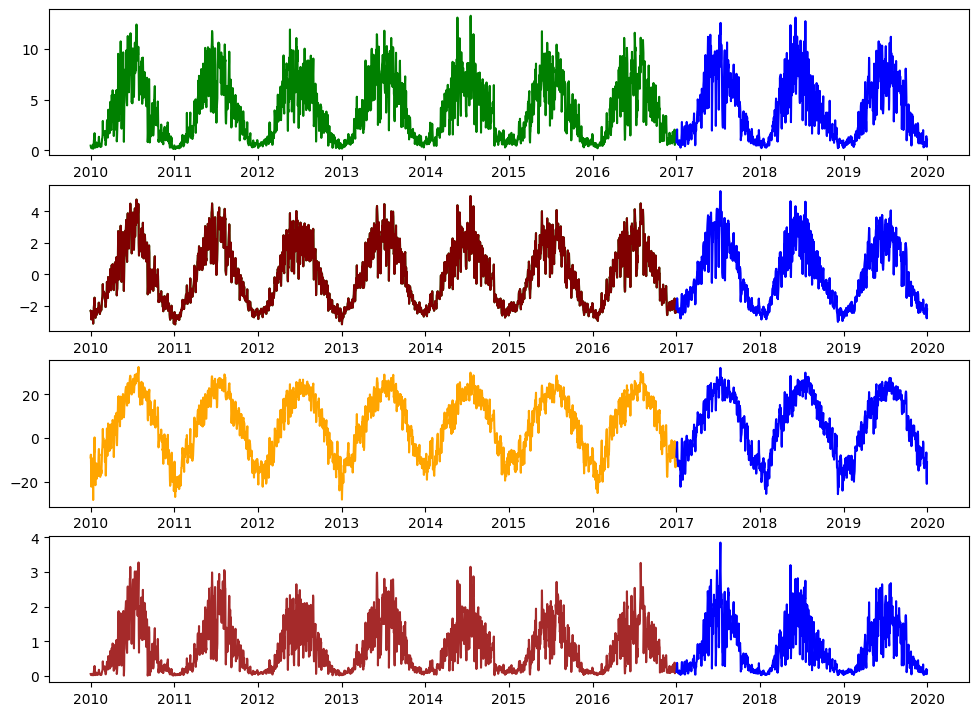

In [473]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

subData = data.loc["2010":"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"].ffill()
z = subData["P1"].ffill()
v = subData["T"].ffill()
w = subData["VPD"].ffill()
plt.subplot(gs[0]).plot(x, y, color='green')

subData_cross = data.loc["2017":]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["ET0"].ffill()
z_cross = subData_cross["P1"].ffill()
v_cross = subData_cross["T"].ffill()
w_cross = subData_cross["VPD"].ffill()
plt.subplot(gs[0]).plot(x_cross, y_cross, color='blue')

plt.subplot(gs[1]).plot(x, z, color='green')
plt.subplot(gs[1]).plot(x_cross, z_cross, color='blue')


plt.subplot(gs[1]).plot(x, z, color='maroon')
plt.subplot(gs[1]).plot(x_cross, z_cross, color='blue')

plt.subplot(gs[2]).plot(x, v, color='orange')
plt.subplot(gs[2]).plot(x_cross, v_cross, color='blue')

plt.subplot(gs[3]).plot(x, w, color='brown')
plt.subplot(gs[3]).plot(x_cross, w_cross, color='blue')

In [474]:
def metrics(y1, y2):
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################
def Mlinear(theta, X):
    n = X.shape[1]
    M = theta[: n]
    B = theta[n] 
    y = X.dot(M) + B
    return y
########################################

def LNR(X, y):
    n = X.shape[1]
    def step(theta):
        yp_linear = Mlinear(theta, X)
        return np.sum((y-yp_linear)**2)

    return step
########################################

def funcMAX(func, X, y, addParam = 0, maxiter=500, method='L-BFGS-B', verbose=False):
  t1 =  datetime.now()
  ###########################################
  n = X.shape[1]
  # Maximum Likelihood
  Param_init = np.random.rand(n+addParam)
  result = minimize(func(X, y), Param_init, 
                method=method, options={"maxiter":maxiter})
  print("--------------------")
  if verbose:
    print(result)
  ###########################################
  if not verbose: 
    print("Fit Success: ", result.success)
  t2 =  datetime.now()
  print("Execution time: ", t2-t1)
  print("--------------------")
  return result

In [475]:
def linearML(y, y_cross, nDelay = 3, z=None, z_cross=None):

  XS, ys = dataPrepare(y, nDelay, z=z)
  XS_cross, ys_cross = dataPrepare(y_cross, nDelay, z=z_cross)
  
  print("Training data X-shape: ", XS.shape)
  print("Training data y-shape: ", ys.shape)
  print("Test data X-shape: ", XS_cross.shape)
  print("Test data y-shape: ", ys_cross.shape)

  # training the linear model
  theta = funcMAX(LNR, XS, ys, addParam = 1).x

  yp_cross = Mlinear(theta, XS_cross)
  yp = Mlinear(theta, XS)

  metrics(ys, yp)
  metrics(ys_cross, yp_cross)

  plt.plot(np.abs(theta), 'ro')

  return ys, yp, ys_cross, yp_cross

In [476]:


def dataPrepare(y, n = 3, z=None):
  N = len(y)
  
  if z is not None:
    XS = np.zeros((N-n, 2*n))
  else:
    XS = np.zeros((N-n, n))
  ys = np.zeros(N-n)
  for i in range(0, N-n):
    XS[i,:n] = y[i:i+n]
    if z is not None:
      XS[i,n:2*n] = z[i:i+n]
    ys[i] = y[i+n]
  
  return XS, ys


Training data X-shape:  (2552, 5)
Training data y-shape:  (2552,)
Test data X-shape:  (1090, 5)
Test data y-shape:  (1090,)
--------------------
Fit Success:  True
Execution time:  0:00:00.010971
--------------------
MAE: 0.90  RMSE: 1.31  R^2: 0.80
MAE: 0.93  RMSE: 1.34  R^2: 0.80
Training data X-shape:  (2552, 5)
Training data y-shape:  (2552,)
Test data X-shape:  (1090, 5)
Test data y-shape:  (1090,)
--------------------
Fit Success:  True
Execution time:  0:00:00.017520
--------------------
MAE: 0.42  RMSE: 0.60  R^2: 0.90
MAE: 0.44  RMSE: 0.64  R^2: 0.89
Training data X-shape:  (2552, 5)
Training data y-shape:  (2552,)
Test data X-shape:  (1090, 5)
Test data y-shape:  (1090,)
--------------------
Fit Success:  True
Execution time:  0:00:00.018673
--------------------
MAE: 2.47  RMSE: 3.19  R^2: 0.95
MAE: 2.41  RMSE: 3.15  R^2: 0.95
Training data X-shape:  (2552, 5)
Training data y-shape:  (2552,)
Test data X-shape:  (1090, 5)
Test data y-shape:  (1090,)
--------------------
Fit Su

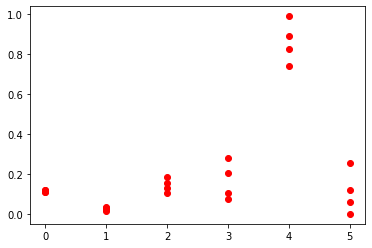

In [477]:
nDelay = 5
ys, yp, ys_cross, yp_cross = linearML(y, y_cross, nDelay = nDelay)
zs, zp, zs_cross, zp_cross = linearML(z, z_cross, nDelay = nDelay)
vs, vp, vs_cross, zp_cross = linearML(v, v_cross, nDelay = nDelay)
ws, wp, ws_cross, wp_cross = linearML(w, w_cross, nDelay = nDelay)



In [493]:
from scipy.stats import spearmanr

yr = ys-yp
zr = zs-zp
corr, _ = spearmanr(ys[2:], ys[:-2])
print('Spearmans correlation: %.3f' % corr)

metrics(ys[1:], ys[:-1])


Spearmans correlation: 0.851
MAE: 0.95  RMSE: 1.40  R^2: 0.77


In [479]:
def dataPrepare2(y, z, v, w, n = 3):

  N = len(y)
  XS = np.zeros((N-n, 4*n))

  ys = np.zeros(N-n)
  for i in range(0, N-n):
    XS[i,:n] = w[i:i+n]  
    XS[i,n:2*n] = v[i:i+n]
    XS[i,2*n:3*n] = y[i:i+n]   
    XS[i,3*n:4*n] = z[i:i+n] 

    
    ys[i] = y[i+n]
  # 
  return XS, ys

--------------------
Fit Success:  True
Execution time:  0:00:00.011499
--------------------
MAE: 0.84  RMSE: 1.22  R^2: 0.82
MAE: 0.86  RMSE: 1.27  R^2: 0.82


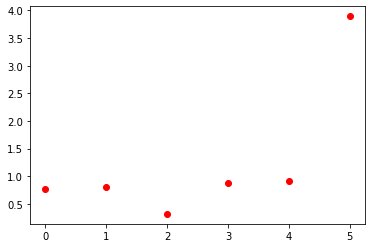

In [513]:
mDelay = 3

XS2, ys2 = dataPrepare2(y, z, v, w, n=mDelay)
XS_cross2, ys_cross2 = dataPrepare2(y_cross, z_cross, v_cross, w_cross, n=mDelay)

#############################################
scalar = StandardScaler()
pca = PCA(n_components=5)

XS2 = scalar.fit_transform(XS2)
XS2 = pca.fit_transform(XS2)

XS_cross2 = scalar.transform(XS_cross2)
XS_cross2 = pca.transform(XS_cross2)
#############################################


theta2 = funcMAX(LNR, XS2, ys2, addParam=1).x
yp_cross2 = Mlinear(theta2, XS_cross2)
yp2 = Mlinear(theta2, XS2)
metrics(ys2, yp2)
metrics(ys_cross2, yp_cross2)
plt.plot(np.abs(theta2), 'ro')

MAE: 0.84  RMSE: 1.22  R^2: 0.79


(-5.0, 20.0)

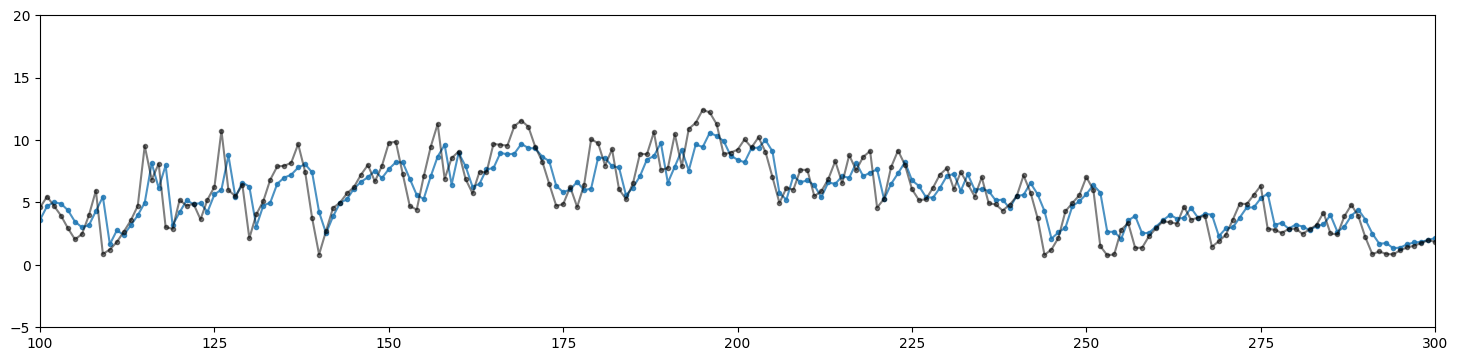

In [514]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(ys2-yp2, 'r')

A = yp2[2:]
B = ys2[2:]
ax.plot(A, '.-', alpha=0.8)
ax.plot(B,'k.-', alpha=0.5)
metrics(A, B)


ax.set_xlim(100,300)
ax.set_ylim(-5,20)

In [552]:
from sklearn.model_selection import train_test_split
def GPR(X, y, lnlikelihood=True):

    n = X.shape[1]
    
    def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
          # X1, X2, y1, y2 = train_test_split(X, y, test_size=0.50)

          # X0_1 = X1 / np.vstack([L]*X1.shape[0])
          # X0_2 = X2 / np.vstack([L]*X2.shape[0])
          
          # gp1 = george.GP(kernel)
          # gp1.compute(X0_1,  yerr)
          # yp2, _ = gp1.predict(y1, X0_2, return_var=True)
          # xi2_2 = np.sum((y2-yp2)**2)

          # gp2 = george.GP(kernel)
          # gp2.compute(X0_2, yerr)
          # yp1, _ = gp2.predict(y2, X0_1, return_var=True)
          # xi2_1 = np.sum((y1-yp1)**2)

          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          # return -gp1.lnlikelihood(y1)-gp2.lnlikelihood(y2)
          return -gp.lnlikelihood(y)
          # return xi2_1 + xi2_2
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
    return step

In [553]:
mDelay = 3

XS2, ys2 = dataPrepare2(y, z, v, w, n=mDelay)
XS_cross2, ys_cross2 = dataPrepare2(y_cross, z_cross, v_cross, w_cross, n=mDelay)

XS_cross2.shape

(1092, 12)

In [554]:
scalar = StandardScaler()
pca = PCA(n_components=5)

XS2 = scalar.fit_transform(XS2)
XS2 = pca.fit_transform(XS2)

XS_cross2 = scalar.transform(XS_cross2)
XS_cross2 = pca.transform(XS_cross2)

(1092, 5)

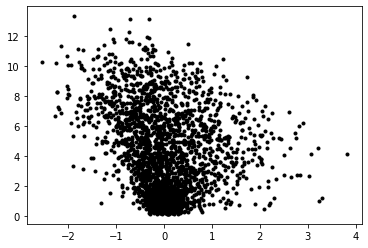

In [555]:
plt.plot(XS2[:,1], ys2, 'k.')
XS_cross2.shape

In [556]:
theta_GPR = funcMAX(GPR, XS2, ys2, addParam = 2).x

--------------------
Fit Success:  True
Execution time:  0:01:51.563849
--------------------


In [566]:
# theta_GPR = np.asarray()
theta_GPR

array([2.18822359, 2.50666528, 2.40324584, 2.499902  , 0.73996892,
       3.57875976, 0.18316462])

In [567]:
### Best Kernel
### 10 lags, just data
# theta_GPR = np.asarray([4.62127798, 1.76995744, 4.52521886, 1.82761624, 2.21764215,
#        3.68138378, 1.69673639, 1.69440516, 3.97984251, 1.56267601,
#        2.53874497, 0.11774556])

In [568]:
gp = GPR(XS2, ys2, lnlikelihood=False)(theta_GPR)

In [571]:
n = XS2.shape[1]
m_cross = XS_cross2.shape[0]
m = XS2.shape[0]
L = np.exp(theta_GPR[:n])

# gp_yp_cross, _ = gp.predict(ys2, XS_cross2, return_var=True)
# gp_yp, _ = gp.predict(ys2, XS2, return_var=True)

gp_yp_cross, gp_yp_cross_std = gp.predict(ys2, XS_cross2/np.vstack([L]*m_cross), return_var=True)
gp_yp, _ = gp.predict(ys2, XS2/np.vstack([L]*m), return_var=True)

metrics(ys2, gp_yp)
metrics(ys_cross2, gp_yp_cross)

MAE: 0.82  RMSE: 1.20  R^2: 0.83
MAE: 0.85  RMSE: 1.26  R^2: 0.82


(0.0, 365.0)

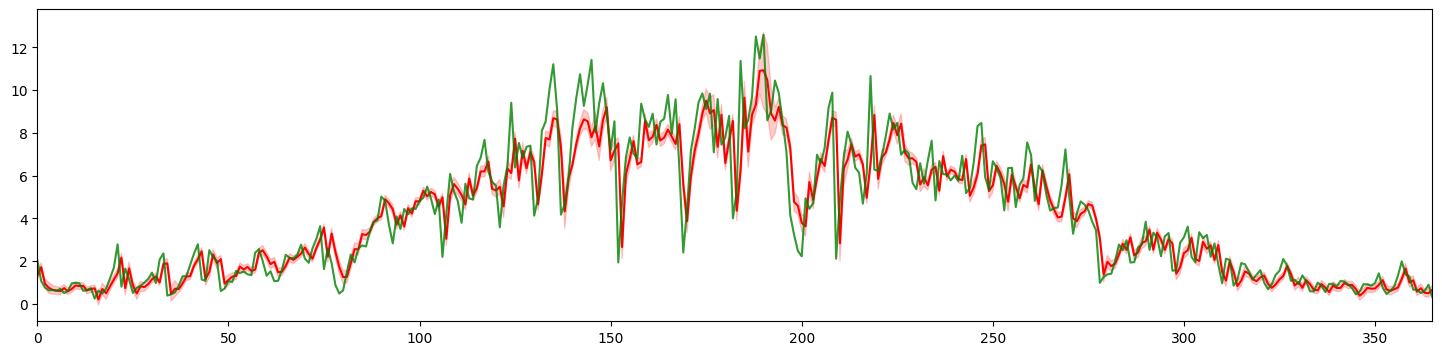

In [580]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(gp_yp_cross, 'r-',  alpha=1)
ax.plot(ys_cross2, 'g-', alpha=0.8)

ax.fill_between(range(len(gp_yp_cross)), gp_yp_cross - 3.*np.sqrt(gp_yp_cross_std), gp_yp_cross + 3.*np.sqrt(gp_yp_cross_std),
                color="r", alpha=0.2)


ax.set_xlim(0,365)

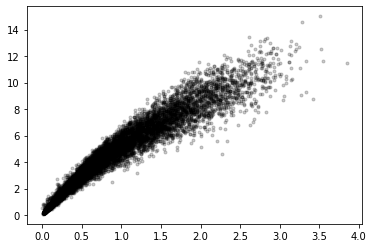

In [86]:
plt.plot(data['VPD'], data['ET0'],'k.', alpha=0.2)


In [51]:
#Pearsons correlation:
np.cov(data['VPD'], data['ET0']) / (np.std(data['VPD']) * np.std(data['ET0']))

array([[0.24040151, 0.96735316],
       [0.96735316, 4.16046695]])

In [ ]:
from scipy.stats import spearmanr
# seed random number generator


# calculate spearman's correlation
corr, _ = spearmanr(data['VPD'][:-1], data['ET0'][1:])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
yr = ys-yp

plt.plot(yr)

corr, _ = spearmanr(yr[1:], ys[:-1])
print('Spearmans correlation: %.3f' % corr)

In [ ]:
plt.plot(yp, ys-yp, 'k.', alpha=0.1)

fit = np.polyfit(yp, ys-yp, 3)

xx = np.linspace(0,10,1000)
plt.plot(xx, fit[0]*xx**2+fit[1]*xx+fit[2])